In [1]:
from multiprocessing import Pool
import numpy as np
from graph import Circle, Grid, RandomRegular, GraphByDegrees, ErdosRenyi, ScaleFree, SmallWorld
from viz import draw_data
from utils import Timer, partition
from engine import fun
from engine_mono import fun_mono
from engine_sum import fun_sum
from engine_tot import fun_tot
from graph_toolset import coreness, degs
import jupyternotify
import random
import matplotlib.cm as cm
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

# from scipy.misc import imresize
"""
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
"""
import matplotlib.pyplot as plt


from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

import pickle

%matplotlib notebook

ModuleNotFoundError: No module named 'graph'

In [2]:
def total(graph, keys):
    res = dict()
    if 'rho' in keys:
        res['rho'] = graph.V
    if 'l' in keys:
        res['l'] = graph.V
    return res

In [3]:
def total_star(graph, keys):
    res = dict()
    for v in graph.V:
        key = f'star{v}'
        if key in keys:
            res[key] = [v]
    return res

In [4]:
def addr(filename):
    return '/home/zhuk1996/data/' + filename + '.pkl'

In [5]:
def all_keys(n):
    return [f'star{v}' for v in range(n)]

In [6]:
def calc(fun_name, alphas, bs, graphs, T, out_file, keys, init_type='01', set_builder=total_star, pool_size=32):
    pool = Pool(pool_size)
    
    res = dict()
    for key in keys:
        res[key] = []

    timer = Timer()
    
    now = 0
    
    for graph in graphs:
        local_timer = Timer()
        
        sets = set_builder(graph, keys)
        
        points = [(graph, b, alpha, T, init_type, sets) for alpha in alphas for b in bs]
        
        if fun_name == 'fun':
            cur = pool.map(fun, points)
        elif fun_name == 'mono':
            cur = pool.map(fun_mono, points)
        elif fun_name == 'sum':
            cur = pool.map(fun_sum, points)
        elif fun_name == 'tot':
            cur = pool.map(fun_tot, points)
        else:
            raise Exception(f'dont know fun name {fun_name}!')
        
        for key in keys:
            tmp = []
            for step in cur:
                tmp.append(step[key])
            
            tmp = np.array(tmp)
            tmp = np.reshape(tmp, (len(alphas), len(bs), tmp.shape[1]))
            res[key].append(tmp)
        
        t = local_timer.measure()
        now += 1
        # rem = len(graphs) - now
        # print(f'#{now} passed in {local_timer.measure()},  projected end in {timer.measure() / now * rem / 60} minutes', flush=True)
        
    for key in keys:
        res[key] = np.array(res[key])
        
    timer.print_elapsed()
    
    with open(addr(out_file), 'wb') as f:
        pickle.dump(res, f)
    
    print(f'Written to {addr(out_file)}')
    

In [7]:
def cut_alpha(data, alpha_id):
    res = dict()
    for key, arr in data.items():
        res[key] = arr[:, alpha_id, :, :]
    return res

In [8]:
def plot_means(bs, data, last, keys, title, show_data=False):
    fig, ax = plt.subplots()
    
    for key in keys:
        cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
        if show_data:
            for t in cur:
                ax.scatter(bs, t, s=1, alpha=.5)

        cur = np.apply_along_axis(np.mean, 0, cur)
        # cur = np.apply_along_axis(np.median, 0, cur)
        ax.plot(bs, cur, '-', label=f'{key}')
    # ax.legend()
    ax.set_title(title)
    plt.show()

In [9]:
def single(bs, filename, keys, name):
    fig, ax = plt.subplots(figsize=(3 * 3, 2.5 * 2))
    plt.locator_params(axis='y', nbins=10)
    plt.locator_params(axis='x', nbins=11)
    
    with open(addr(filename), 'rb') as f:
        data = cut_alpha(pickle.load(f), 0)

        
        for key in keys:
            cur = data[key]
            LEN = cur.shape[-1]
            for t in cur:
                ax.scatter(list(range(LEN)), t[0], s=3, alpha=.1, c='blue')

        ax.hlines(y=list(range(1, 10)), xmin=0, xmax=LEN, linestyle='-',linewidth=.2)
        
        ax.set_xlabel(r'$t$')
        ax.set_ylabel(r'$b^*$')
        ax.set_ylim((.1, 10))
        ax.set_title(name)

    plt.show()

In [10]:
def ER(t):
    return ErdosRenyi(*t)

def SF(t):
    return ScaleFree(*t)

def WS(t):
    return SmallWorld(*t)

def er_graphs(cnt, n, k):
    for _ in range(cnt):
        yield ErdosRenyi(n, k / n)

def sf_graphs(cnt, n, m):
    for _ in range(cnt):
        yield ScaleFree(n, m)

def ws_graphs(cnt, n, k, beta):
    for _ in range(cnt):
        yield SmallWorld(n, k, beta)
    
def r_graphs(cnt, degs):
    for _ in range(cnt):
        yield GraphByDegrees(degs)

In [11]:
def run_and_draw(name, fun, graphs, n, steps, picname='hoba'):
    timer = Timer()    
    calc(fun, alphas, bs, graphs, steps, name, all_keys(n))
    print(f'overall time = {timer.measure() / 60} mins')
    # single(bs, name, all_keys(n), picname)
    multi(bs, name, all_keys(n), picname)

In [12]:
bs = partition(1, 10, 128)
alphas = [.1]
print(bs)
print(alphas)

[ 1.0703125  1.140625   1.2109375  1.28125    1.3515625  1.421875
  1.4921875  1.5625     1.6328125  1.703125   1.7734375  1.84375
  1.9140625  1.984375   2.0546875  2.125      2.1953125  2.265625
  2.3359375  2.40625    2.4765625  2.546875   2.6171875  2.6875
  2.7578125  2.828125   2.8984375  2.96875    3.0390625  3.109375
  3.1796875  3.25       3.3203125  3.390625   3.4609375  3.53125
  3.6015625  3.671875   3.7421875  3.8125     3.8828125  3.953125
  4.0234375  4.09375    4.1640625  4.234375   4.3046875  4.375
  4.4453125  4.515625   4.5859375  4.65625    4.7265625  4.796875
  4.8671875  4.9375     5.0078125  5.078125   5.1484375  5.21875
  5.2890625  5.359375   5.4296875  5.5        5.5703125  5.640625
  5.7109375  5.78125    5.8515625  5.921875   5.9921875  6.0625
  6.1328125  6.203125   6.2734375  6.34375    6.4140625  6.484375
  6.5546875  6.625      6.6953125  6.765625   6.8359375  6.90625
  6.9765625  7.046875   7.1171875  7.1875     7.2578125  7.328125
  7.3984375  7.46875 

In [13]:
def extract(bag):
    DIGITS = 2
    CNT = 300
    cnt = dict()
    relevant = 0
    for x in filter(lambda x: 1 < x <= 10, bag):
        x = round(x, DIGITS)
        cnt[x] = cnt.get(x, 0) + 1
        relevant += 1
    # print(list(map(lambda x: x / relevant, sorted(cnt.values())[-min(10, len(cnt)):])))
    threshold = sorted(cnt.values())[-min(CNT, len(cnt))]
    bag = list(filter(lambda x: cnt.get(round(x, DIGITS), 0) >= threshold, bag))
    # print(len(bag))
    # ax.scatter([b] * len(bag), bag, s=1, alpha=.01, c='blue')
    rem = list(filter(lambda t: t[1] >= threshold, cnt.items()))
    ys = list(map(lambda t: t[0], rem))
    cs = list(map(lambda t: t[1], rem))
    ss = list(map(lambda t: t[1] / relevant * len(ys), rem))
    return ys, ss, cs
    
def multi(bs, filename, keys, name):
    fig, ax = plt.subplots(figsize=(3 * 3, 2.5 * 2))
    plt.locator_params(axis='y', nbins=10)
    plt.locator_params(axis='x', nbins=11)
    
    with open(addr(filename), 'rb') as f:
        data = cut_alpha(pickle.load(f), 0)

        store = np.concatenate(
            [np.array([data[key][:, i, :].flatten() for i in range(len(bs))]) for key in keys],
            axis=1
        )
        print(store.shape)
        
        # for b, (ys, ss, cs) in zip(bs, Pool(32).map(extract, store)):
        #    ax.scatter([b] * len(ys), ys, s=ss, c=cs, cmap='Blues')
        
        tot = [(b, y, s, c) 
               for (b, pool) in zip(bs, Pool(32).map(extract, store))
               for (y, s, c) in zip(*pool)
              ]
        tot = list(sorted(tot, key=lambda t: t[3]))
        bs = list(map(lambda t: t[0], tot))
        ys = list(map(lambda t: t[1], tot))
        ss = list(map(lambda t: t[2], tot))
        cs = list(map(lambda t: t[3], tot))
        
        ax.scatter(bs, ys, s=1, c=cs, cmap='Blues')
        
        #ax.hlines(y=list(range(1, 10)), xmin=bs[0], xmax=bs[-1], linestyle='-',linewidth=.2)
        
        ax.set_xlabel(r'$b$')
        ax.set_ylabel(r'$b^*$')
        ax.set_ylim((.1, 10))
        ax.set_title(name)

    plt.show()

time elapsed = 589.204110622406
Written to /home/zhuk1996/data/star_er.pkl
overall time = 10.622176166375478 mins


<IPython.core.display.Javascript object>


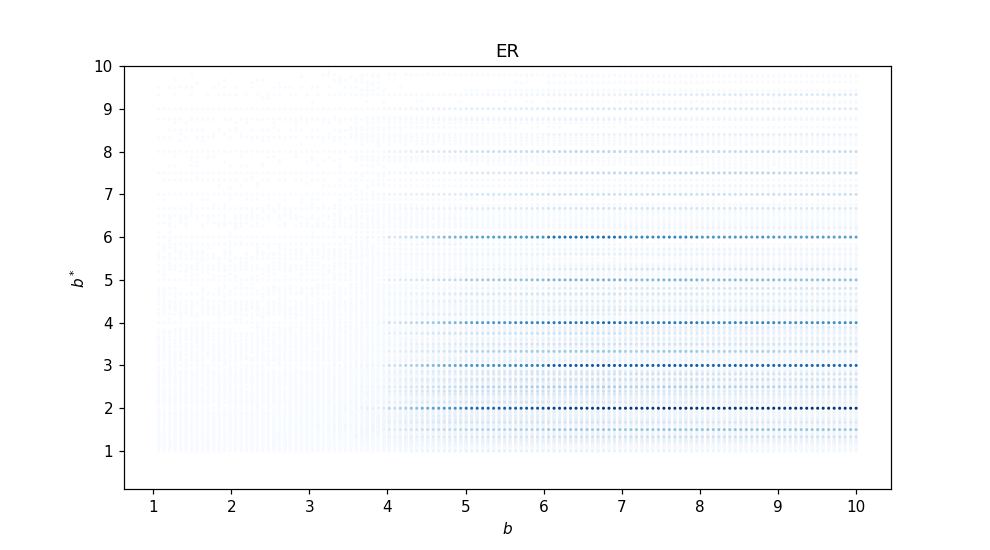

(128, 5000000)


In [14]:
run_and_draw('star_er', 'fun', er_graphs(10, 500, 5), 500, 1000, 'ER')

time elapsed = 15.595837116241455
Written to /home/zhuk1996/data/star_r23.pkl
overall time = 0.2953037261962891 mins


<IPython.core.display.Javascript object>


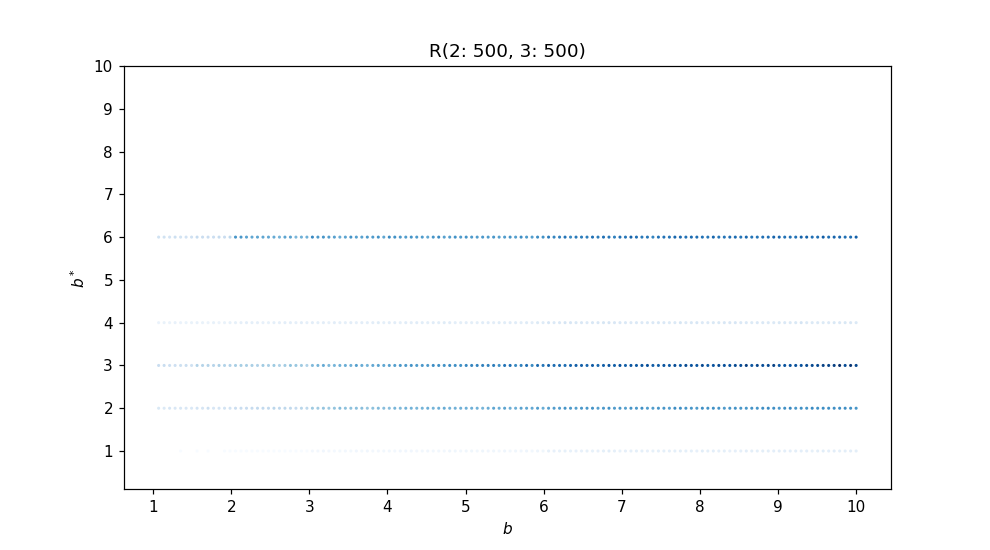

(128, 100000)


In [16]:
run_and_draw('star_r23', 'fun', r_graphs(10, {2: 500, 3: 500}), 1000, 10, 'R(2: 500, 3: 500)')

time elapsed = 172.33559346199036
Written to /home/zhuk1996/data/star_sf.pkl
overall time = 3.094102621078491 mins


<IPython.core.display.Javascript object>


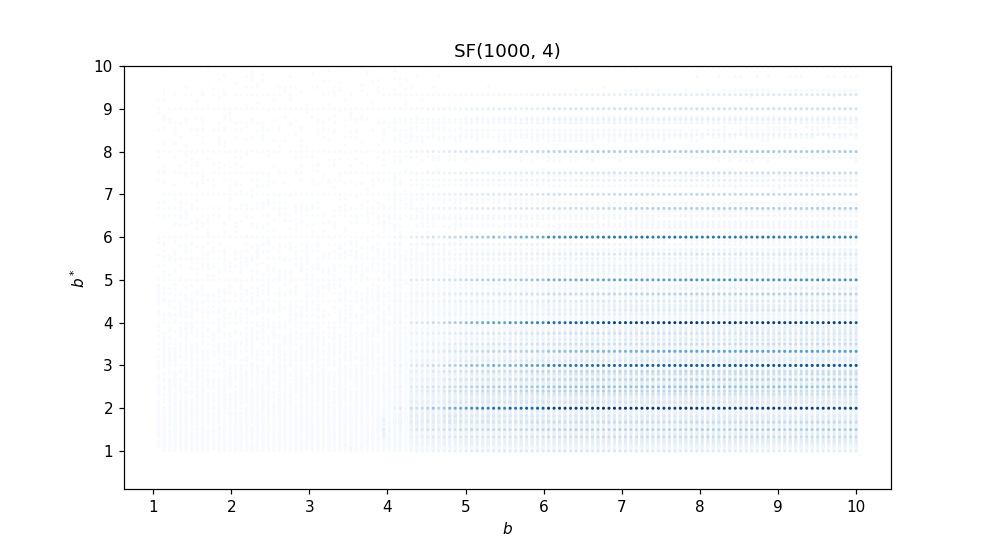

(128, 1000000)


In [20]:
run_and_draw('star_sf', 'fun', sf_graphs(1, 1000, 4), 1000, 1000, 'SF(1000, 4)')

time elapsed = 127.63311839103699
Written to /home/zhuk1996/data/star_r35.pkl
overall time = 2.344255479176839 mins


<IPython.core.display.Javascript object>


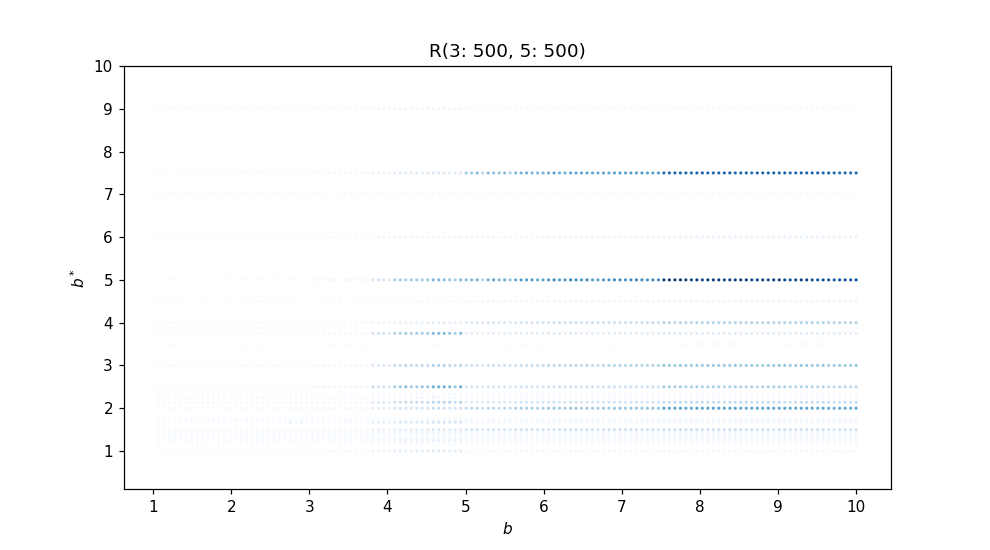

(128, 1000000)


In [17]:
run_and_draw('star_r35', 'fun', r_graphs(1, {3: 500, 5: 500}), 1000, 1000, 'R(3: 500, 5: 500)')

In [ ]:
run_and_draw('star_r35', 'fun', r_graphs(1, {3: 300, 5: 300}), 600, 1000, 'R(3: 300, 5: 300)')

time elapsed = 3.827833414077759
Written to /home/zhuk1996/data/star_r23.pkl
overall time = 0.07944994767506917 mins


<IPython.core.display.Javascript object>


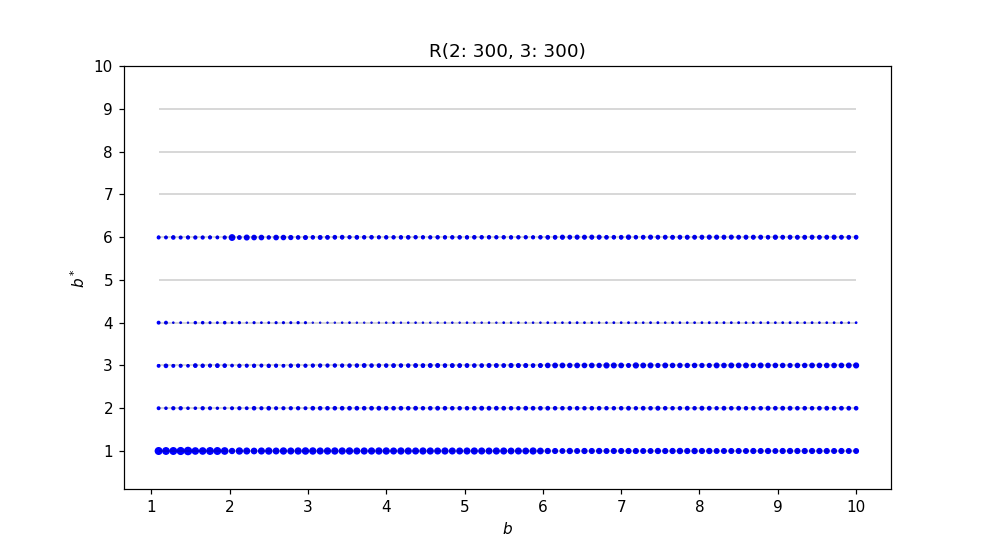

(96, 60000)


In [16]:
run_and_draw('star_r23', 'fun', r_graphs(1, {2: 300, 3: 300}), 600, 100, 'R(2: 300, 3: 300)')

time elapsed = 5.477299213409424
Written to /home/zhuk1996/data/star_r4.pkl
overall time = 0.11016115744908651 mins


<IPython.core.display.Javascript object>


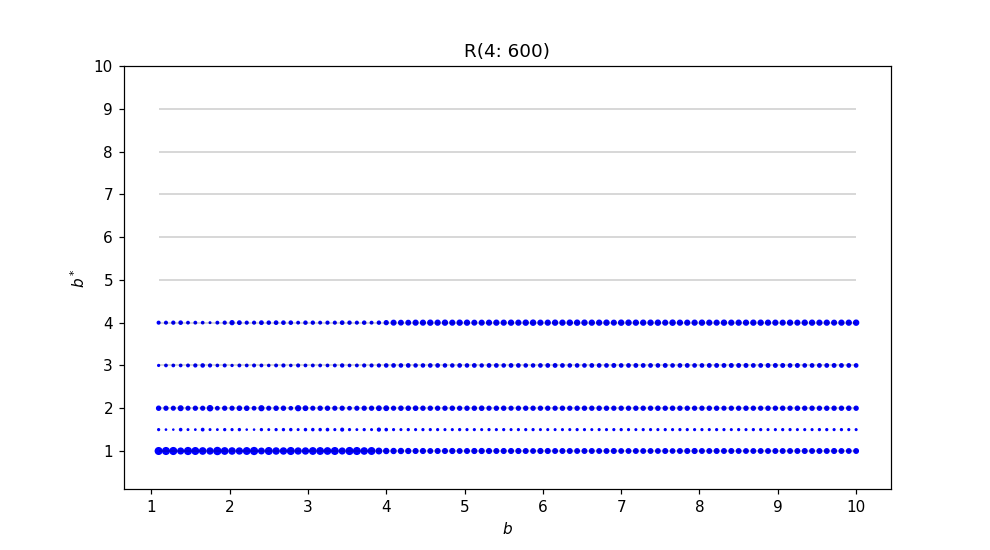

(96, 60000)


In [17]:
run_and_draw('star_r4', 'fun', r_graphs(1, {4: 600}), 600, 100, 'R(4: 600)')

time elapsed = 6.682387828826904
Written to /home/zhuk1996/data/star_r35.pkl
overall time = 0.15314477682113647 mins


<IPython.core.display.Javascript object>


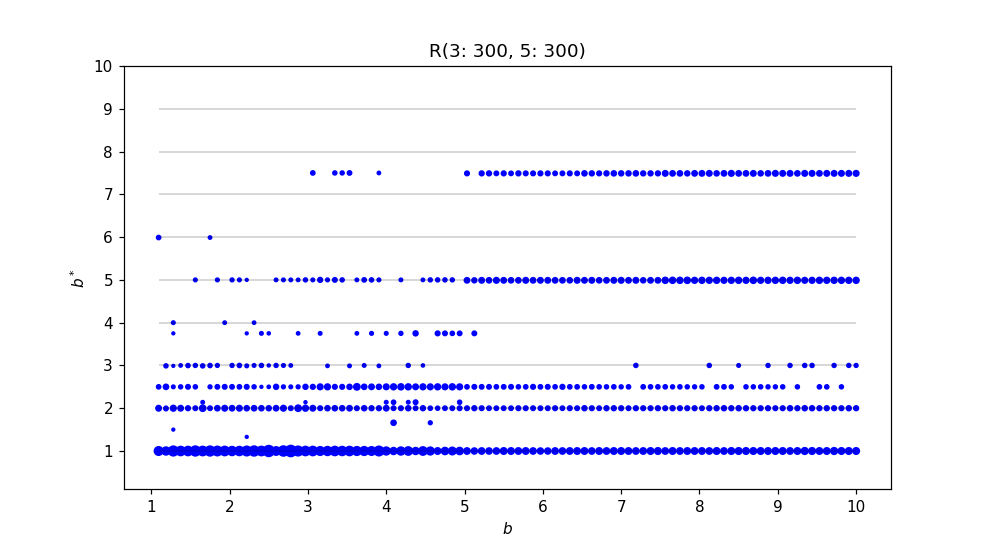

(96, 60000)


In [26]:
run_and_draw('star_r35', 'fun', r_graphs(1, {3: 300, 5: 300}), 600, 100, 'R(3: 300, 5: 300)')